# GPT-4o Research Agent in LangGraph

**Research agents** are multi-step LLM agents that through multiple steps can produce in depth research reports on a topic of our choosing. Most research agents are packed up into their own frameworks, like BlockAGI and others.

In this example, we want to demonstrate how we can build our own AI research agent using `gpt-4o`, Pinecone, LangGraph, arXiv, and Google via the SerpAPI.

We need these prerequisite libraries to run a graph visualization library (`pygraphviz`). We will use this library during this notebook to understand the structure of our graphs _but_ it is not required to use `langgraph`.

In [1]:
!apt-get install graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6).
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Now we install Python libraries:

In [2]:
!pip install -qU \
    datasets==2.19.1 \
    langchain-pinecone==0.1.0 \
    langchain-openai==0.1.3 \
    langchain==0.1.16 \
    langchain-core==0.1.42 \
    langgraph==0.0.37 \
    langchainhub==0.1.15 \
    semantic-router==0.0.39 \
    serpapi==0.1.5 \
    google-search-results==2.4.2 \
    pygraphviz==1.12  # for visualizing

## Research Agent Overview

Our research agent will consist of a function calling AI agent that has access to several tools that it can use to find information on a particular topic. It will be able to use several tools over multiple steps, meaning it can find information on one topic, broaden the scope of knowledge on this topic and _even_ investigate parallel topics where relevant.

The tools we will be using are:

* **ArXiv paper fetch**: Given an arXiv paper ID, this tool provides our agent with the abstract of the paper.
* **Web search**: This tool provides our agent with access to Google search for more generalized queries.
* **RAG search**: We will create a knowledge base containing AI arXiv papers. This tool provides our agent with access to this knowledge.
* **RAG search with filter**: Sometimes our agent may need more information from a specific paper, this tool allows our agent to do just that.
* **Final answer**: We create a custom final answer tool that forces our agent to output information in a specific format like:

```
TK
```

## Setup Knowledge Base

We'll be running our agent against a knowledge base — which requires a Pinecone index to be built.

You can, if needed, skip this step and replace the `search` tool with a placeholder value if wanting to quickly test the structure of a RAG agent _without_ the RAG.

If you want full functionality here, you do need to run this section — but we'll make it quick.

### Download a Dataset

The first thing we need for an agent using RAG is somewhere we want to pull knowledge from. We will use v2 of the AI ArXiv dataset, available on Hugging Face Datasets at [`jamescalam/ai-arxiv2-chunks`](https://huggingface.co/datasets/jamescalam/ai-arxiv2-chunks).

Note: we're using the prechunked dataset. For the raw version see [`jamescalam/ai-arxiv2`](https://huggingface.co/datasets/jamescalam/ai-arxiv2).

In [3]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 209760
})

In [4]:
dataset[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

In [5]:
import requests

res = requests.get(
    f"http://export.arxiv.org/api/query",
    json={
        "id_list": "2401.04088"
    }
)
res

<Response [200]>

In [6]:
arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

In [7]:
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

Building a knowledge base:

In [8]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

encoder = OpenAIEncoder(name="text-embedding-3-small")

In [9]:
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

# configure client
pc = Pinecone(api_key=api_key)

In [10]:
from pinecone import ServerlessSpec

spec = ServerlessSpec(
    cloud="aws", region="us-west-2"  # us-east-1
)

In [11]:
dims = len(encoder(["some random text"])[0])
dims

1536

In [12]:
import time

index_name = "gpt-4o-research-agent"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=dims,  # dimensionality of embed 3
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

Populate our knowledge base:

In [13]:
from tqdm.auto import tqdm

# easier to work with dataset as pandas dataframe
data = dataset.to_pandas().iloc[:10000]

batch_size = 128

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    batch = data[i:i_end].to_dict(orient="records")
    # get batch of data
    metadata = [{
        "title": r["title"],
        "content": r["content"],
        "arxiv_id": r["arxiv_id"],
        "references": r["references"].tolist()
    } for r in batch]
    # generate unique ids for each chunk
    ids = [r["id"] for r in batch]
    # get text content to embed
    content = [r["content"] for r in batch]
    # embed text
    embeds = encoder(content)
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

  0%|          | 0/79 [00:00<?, ?it/s]

## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [14]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Custom Tools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### ArXiv Paper Fetch

The `fetch_arxiv` tool will allow our agent to get the summary of a specific paper given an ArXiv paper ID. To do this, we will simply send a GET request to arXiv and use regex to extract the paper abstract.

In [15]:
import requests

# we will test with the mixtral paper
arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

There's a lot going on there. Fortunately, we can use some _relatively_ straightforward regex to find the paper abstract.

In [16]:
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# we search
re_match = abstract_pattern.search(res.text)

# and now let's see what we got
print(re_match.group(1))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


Now we pack all of this logic into a tool for our agent to use.

In [17]:
from langchain_core.tools import tool


@tool("fetch_arxiv")
def fetch_arxiv_tool(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

Let's test the tool.

In [18]:
print(fetch_arxiv_tool(tool_input=arxiv_id))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

In [19]:
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}

search = GoogleSearch({
    **serpapi_params,
    "q": "coffee"
})

results = search.get_dict()["organic_results"]

In [20]:
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

In [21]:
print(contexts)

Coffee
Coffee is a beverage brewed from roasted coffee beans. Darkly colored, bitter, and slightly acidic, coffee has a stimulating effect on humans, primarily due ...
https://en.wikipedia.org/wiki/Coffee
---
What is Coffee?
Coffee traces its origin to a genus of plants known as Coffea. Within the genus there are over 500 genera and 6,000 species of tropical trees and shrubs.
https://www.ncausa.org/About-Coffee/What-is-Coffee
---
Starbucks Coffee Company
More than just great coffee. Explore the menu, sign up for Starbucks® Rewards, manage your gift card and more.
https://www.starbucks.com/
---
Coffee | Origin, Types, Uses, History, & Facts
Coffee, beverage brewed from the roasted and ground seeds of the tropical evergreen coffee plant of African origin. Coffee is one of the ...
https://www.britannica.com/topic/coffee
---
Coffee | The Nutrition Source - HSPH.Harvard.edu
Low to moderate doses of caffeine (50–300 mg) may cause increased alertness, energy, and ability to concentrate, while

We put this process into a tool:

In [22]:
@tool("web_search")
def web_search_schema(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

### RAG Tools

In [23]:
from langchain_core.tools import tool


@tool("rag_search_filter")
def rag_search_filter_schema(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
    contexts = "\n---\n".join(
        [x["metadata"]["content"] for x in xc["matches"]]
    )
    return contexts

@tool("rag_search")
def rag_search_schema(query: str):
    """Finds specialist information on AI using a natural language query."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=2, include_metadata=True)
    contexts = "\n---\n".join(
        [x["metadata"]["content"] for x in xc["matches"]]
    )
    return contexts

In [24]:
@tool("final_answer")
def final_answer_schema(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Initialize Agent

In [26]:
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

prompt = hub.pull("hwchase17/openai-functions-agent")

oracle_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[
        rag_search_filter_schema,
        rag_search_schema,
        fetch_arxiv_tool,
        web_search_schema,
        final_answer_schema
    ],
    prompt=prompt
)

In [27]:
prompt.messages[0].prompt.template = """
You are the ultimate AI research assistant. Your objective is to help users
dive into the details of research papers. Typically a user will ask a question,
you must use the various tools at your disposal to find more information, using the
rag_search, web_search, rag_search_filter, and fetch_arxiv tools to maximize the
amount of information on the topic.

In no case should you use the rag_search tool more than once.

Once you have completed information gathering, you must provide a small report
to the user via the final_answer tool.
"""

Test the agent quickly to confirm it is functional:

In [28]:
inputs = {
    "input": "tell me something interesting about dogs",
    "chat_history": [],
    "intermediate_steps": [],
}
agent_out = oracle_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='rag_search', tool_input={'query': 'interesting facts about dogs'}, log="\nInvoking: `rag_search` with `{'query': 'interesting facts about dogs'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UEn1BlIpHf2oOlAVGH92gI5n', 'function': {'arguments': '{"query":"interesting facts about dogs"}', 'name': 'rag_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 561, 'total_tokens': 579}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_729ea513f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-018f6f22-2774-43d0-9ebb-6fadabb06179-0', tool_calls=[{'name': 'rag_search', 'args': {'query': 'interesting facts about dogs'}, 'id': 'call_UEn1BlIpHf2oOlAVGH92gI5n'}])], tool_call_id='call_UEn1BlIpHf2oOlAVGH92gI5n')]

In [29]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_UEn1BlIpHf2oOlAVGH92gI5n',
 'function': {'arguments': '{"query":"interesting facts about dogs"}',
  'name': 'rag_search'},
 'type': 'function'}

We would use this information to route our state to either the `search` or `final_answer` nodes of our graph.

## Define Nodes for Graph

In [30]:
from langchain_core.agents import AgentFinish
from langchain_core.messages import AIMessage, HumanMessage
import json

def run_oracle(state: list):
    agent_out = oracle_agent_runnable.invoke(state)
    return {"agent_out": agent_out}


# execute tools
def execute_rag_search_filter(state: list):
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    print(f"execute_rag_search_filter | {tool_call['function']['arguments']}")
    out = rag_search_filter_schema.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    action_out = AgentAction(
        tool="rag_search_filter",
        tool_input=json.loads(tool_call["function"]["arguments"]),
        log=str(out)
    )
    notes = f"""rag_search_filter tool results:
    {out}
    """
    return {
        "intermediate_steps": [(action_out, str(out))],
        "chat_history": [
            *state["chat_history"],
            HumanMessage(content=notes, name="Assistant")
        ]
    }

def execute_rag_search(state: list):
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    print(f"execute_rag_search | {tool_call['function']['arguments']}")
    out = rag_search_schema.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    action_out = AgentAction(
        tool="rag_search",
        tool_input=json.loads(tool_call["function"]["arguments"]),
        log=str(out)
    )
    notes = f"""rag_search tool results:
    {out}"""
    return {
        "intermediate_steps": [(action_out, str(out))],
        "chat_history": [
            *state["chat_history"],
            HumanMessage(content=notes, name="Assistant")
        ]
    }

def execute_fetch_arxiv(state: list):
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    print(f"execute_fetch_arxiv | {tool_call['function']['arguments']}")
    out = fetch_arxiv_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    action_out = AgentAction(
        tool="fetch_arxiv",
        tool_input=json.loads(tool_call["function"]["arguments"]),
        log=str(out)
    )
    notes = f"""fetch_arxiv tool results:
    {out}"""
    return {
        "intermediate_steps": [(action_out, str(out))],
        "chat_history": [
            *state["chat_history"],
            HumanMessage(content=notes, name="Assistant")
        ]
    }

def execute_web_search(state: list):
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    print(f"execute_web_search | {tool_call['function']['arguments']}")
    out = web_search_schema.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    action_out = AgentAction(
        tool="web_search",
        tool_input=json.loads(tool_call["function"]["arguments"]),
        log=str(out)
    )
    notes = f"""execute_search tool results:
    {out}"""
    return {
        "intermediate_steps": [(action_out, str(out))],
        "chat_history": [
            *state["chat_history"],
            HumanMessage(content=notes, name="Assistant")
        ]
    }

def router(state: list):
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"

# finally, we will have a single LLM call that MUST use structured output
final_answer_llm = llm.bind_tools([final_answer_schema], tool_choice="final_answer")

def final_answer(state: list):
    print(f"final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    previous research steps performed:

    RESEARCH STEPS:""" + str(state["chat_history"]) + f"""

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

def handle_error(state: list):
    print(f"handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

## Define Graph

In [31]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search_filter", execute_rag_search_filter)
graph.add_node("rag_search", execute_rag_search)
graph.add_node("fetch_arxiv", execute_fetch_arxiv)
graph.add_node("web_search", execute_web_search)
graph.add_node("error", handle_error)
#graph.add_node("final_answer_aggregator", final_answer)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    start_key="oracle",  # where in graph to start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "rag_search_filter": "rag_search_filter",
        "rag_search": "rag_search",
        "fetch_arxiv": "fetch_arxiv",
        "web_search": "web_search",
        "error": "error",
        "final_answer": END
    }
)
graph.add_edge("rag_search", "oracle")
graph.add_edge("rag_search_filter", "oracle")
graph.add_edge("fetch_arxiv", "oracle")
graph.add_edge("web_search", "oracle")
graph.add_edge("error", END)
#graph.add_edge("final_answer_aggregator", END)

runnable = graph.compile()

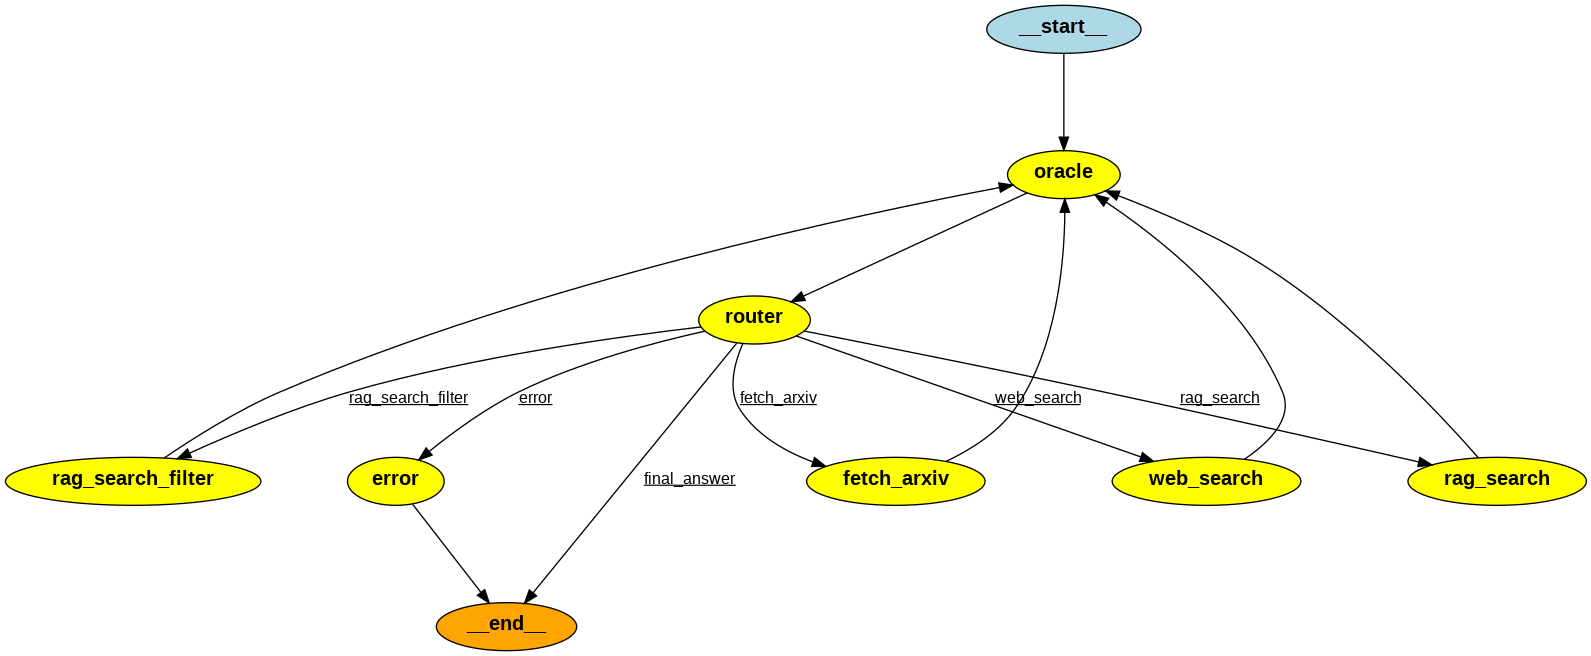

In [32]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [33]:
out = runnable.invoke({
    "input": "tell me something interesting about dogs",
    "chat_history": [],
})

execute_rag_search | {"query":"interesting facts about dogs"}
execute_web_search | {"query":"interesting facts about dogs"}


Let's create a function to consume the agent output and format it into our report:

In [34]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [35]:
print(build_report(output=out["agent_out"][0].tool_input))


INTRODUCTION
------------
Dogs are fascinating creatures with a rich history and a variety of unique traits. They have been companions to humans for thousands of years, and their abilities and behaviors continue to amaze us.

RESEARCH STEPS
--------------
1. Conducted a rag_search to gather specialist information on dogs.
2. Performed a web_search to find general knowledge and interesting facts about dogs.
3. Compiled the most intriguing and lesser-known facts about dogs from various sources.

REPORT
------
One of the most interesting facts about dogs is their incredible sense of smell. Dogs can smell up to 40 times better than humans, thanks to the 300 million olfactory receptors in their noses compared to the 6 million in humans. This extraordinary sense of smell allows them to detect a wide range of scents, from drugs and explosives to diseases like cancer and diabetes.

Dogs also have a remarkable sense of time. Studies have shown that dogs can differentiate between different leng

Now let's try with an on-topic question on AI.

In [46]:
out = runnable.invoke({
    "input": "tell me about AI",
    "chat_history": []
})

execute_rag_search | {"query":"AI"}
execute_web_search | {"query":"AI overview"}


In [47]:
print(build_report(output=out["agent_out"][0].tool_input))


INTRODUCTION
------------
Artificial Intelligence (AI) is a rapidly evolving field that encompasses a wide range of technologies and applications. From personalized learning to autonomous agents, AI is transforming various aspects of our lives.

RESEARCH STEPS
--------------
1. Conducted a rag_search to gather specialist information on AI.
2. Performed a web_search to find general knowledge and recent developments in AI.
3. Compiled and synthesized the information to provide a comprehensive overview.

REPORT
------
Artificial Intelligence (AI) is a broad field that involves the use of data, algorithms, and human feedback to create systems capable of performing tasks that typically require human intelligence. These tasks include learning, reasoning, problem-solving, perception, and language understanding. AI technologies are being applied in various domains, including healthcare, finance, education, and entertainment.

One notable application of AI is in personalized learning and well-

Let's ask about RAG specifically.

In [48]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

execute_rag_search | {"query":"retrieval augmented generation"}
execute_web_search | {"query":"Retrieval-Augmented Generation (RAG)"}


In [49]:
print(build_report(output=out["agent_out"][0].tool_input))


INTRODUCTION
------------
Retrieval-Augmented Generation (RAG) is an advanced AI framework designed to enhance the performance of generative models by integrating external information retrieval mechanisms. This approach aims to address the limitations of large language models (LLMs) by grounding their outputs in accurate and relevant external knowledge.

RESEARCH STEPS
--------------
- Conducted a RAG search to gather specialist information on Retrieval-Augmented Generation.
- Performed a web search to obtain general knowledge and explanations about RAG.
- Compiled and synthesized the information to provide a comprehensive overview of RAG.

REPORT
------
Retrieval-Augmented Generation (RAG) is a technique that combines the strengths of information retrieval systems with generative AI models. The primary goal of RAG is to improve the accuracy and reliability of generative models by incorporating external documents and knowledge bases into the generation process. This is particularly us

---